In [1]:
pip install ipywidgets

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 139 kB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 93.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 23.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.10.2/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install scikit-learn # 用于数据划分

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.10.2/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import random
import time # 导入 time 模块
import matplotlib.pyplot as plt # Import matplotlib for plotting
from sklearn.model_selection import train_test_split # For splitting data

In [4]:
# ## 2. 加载数据和映射关系 (Load Data and Mappings)
#
# - 从 "tang.npz" 文件加载数据。
# - 提取诗歌数据、词到索引的映射 (word2ix) 和索引到词的映射 (ix2word)。

# %%
tang_file = np.load("tang.npz", allow_pickle=True)

data = tang_file['data']
word2ix = tang_file['word2ix'].item()
idx2word = tang_file['ix2word'].item()

print("数据和映射关系加载完成。")
print(f"word2ix 类型: {type(word2ix)}")
print(f"idx2word 类型: {type(idx2word)}")
print(f"共有 {len(data)} 首诗。")

数据和映射关系加载完成。
word2ix 类型: <class 'dict'>
idx2word 类型: <class 'dict'>
共有 57580 首诗。


In [5]:
# ## 3. `idx2poem` 函数定义与示例 (idx2poem Function and Example)
#
# - 定义将索引序列转换为诗歌文本的函数。
# - 打印一首示例诗歌及其特殊标记的索引。

# %%
def idx2poem(idx_poem_list):
    poem_chars = []
    for id_val in idx_poem_list:
        poem_chars.append(idx2word.get(id_val, '<unk>')) # 使用 .get() 以防索引不存在
    return "".join(poem_chars)

print(f"示例诗歌 (data[314]): {idx2poem(data[314])}")

# 确保 word2ix 和 '</s>' 键存在
if '</s>' in word2ix:
    print(f"</s> 对应的索引: {word2ix['</s>']}")
else:
    print("警告: 词典 word2ix 中未找到 '</s>'。")


示例诗歌 (data[314]): </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><START>南楼夜已寂，暗鸟动林间。不见城郭事，沈沈唯四山。<EOP>
</s> 对应的索引: 8292


In [14]:
# ## 4. 诗歌数据预处理 (Poem Preprocessing)
#
# - 移除每首诗歌开头的 `</s>` 标记。
# - 打印处理后的第一首诗歌作为示例。
# - 打印词汇表大小。

# %%
poems_processed = [] # Renamed to avoid conflict later
for poem_indices in data:
    start_index = 0
    if '</s>' not in word2ix: # 检查 '</s>' 是否在词典中
        print("错误: '</s>' 不在 word2ix 中，无法处理诗歌数据。将跳过预处理。")
        poems_processed = data # 或者采取其他错误处理方式
        break
    for index, ix in enumerate(poem_indices):
        if ix == word2ix["</s>"]:
            continue
        else:
            start_index = index
            break
    poems_processed.append(poem_indices[start_index:])

if poems_processed:
    print(f"处理后的第一首诗 (索引): {poems_processed[0]}")
    print(f"处理后的第一首诗 (文本): {idx2poem(poems_processed[0])}")
else:
    print("警告: 处理后诗歌列表为空。")

print(f"词汇表大小: {len(idx2word)}")

处理后的第一首诗 (索引): [8291 6731 4770 1787 8118 7577 7066 4817  648 7121 1542 6483 7435 7686
 2889 1671 5862 1949 7066 2596 4785 3629 1379 2703 7435 6064 6041 4666
 4038 4881 7066 4747 1534   70 3788 3823 7435 4907 5567  201 2834 1519
 7066  782  782 2063 2031  846 7435 8290]
处理后的第一首诗 (文本): <START>度门能不访，冒雪屡西东。已想人如玉，遥怜马似骢。乍迷金谷路，稍变上阳宫。还比相思意，纷纷正满空。<EOP>
词汇表大小: 8293


In [15]:
# ## 4.1. 划分训练集和验证集 (Split into Training and Validation Sets)
# - 将处理后的诗歌数据划分为训练集和验证集。

# %%
train_poems, val_poems = train_test_split(poems_processed, test_size=0.2, random_state=42) # 80% train, 20% val
print(f"训练集诗歌数量: {len(train_poems)}")
print(f"验证集诗歌数量: {len(val_poems)}")

训练集诗歌数量: 46064
验证集诗歌数量: 11516


In [16]:
# ## 5. 创建输入输出序列 (Create Input-Output Sequences)
# - 将所有诗歌连接成一个长序列。
# - 按指定的序列长度 (`seq_len`) 切割成长序列，生成模型的输入 (`X`) 和目标 (`Y`)。
# - 分别为训练集和验证集创建序列。

# %%
seq_len = 48 # 序列长度保持不变

# --- 创建训练集序列 ---
X_train = []
Y_train = []
train_poems_data = [j for i in train_poems for j in i] # Flatten train poems

if len(train_poems_data) <= seq_len :
    print(f"错误: train_poems_data 的长度 ({len(train_poems_data)}) 不足以创建长度为 {seq_len} 的序列。")
    print("请检查数据预处理步骤或减少 seq_len。")
else:
    for i in range(0, len(train_poems_data) - seq_len - 1, seq_len): # 最后一个-1是为了确保Y有对应的下一个词
        X_train.append(train_poems_data[i:i + seq_len])
        Y_train.append(train_poems_data[i + 1:i + seq_len + 1])
    print(f"创建的 X_train 序列数量: {len(X_train)}")
    print(f"创建的 Y_train 序列数量: {len(Y_train)}")

# --- 创建验证集序列 ---
X_val = []
Y_val = []
val_poems_data = [j for i in val_poems for j in i] # Flatten validation poems

if len(val_poems_data) <= seq_len:
    print(f"警告: val_poems_data 的长度 ({len(val_poems_data)}) 不足以创建长度为 {seq_len} 的验证序列。")
    # 如果验证数据太少，可以考虑不使用验证集，或者减少seq_len，或者增加数据
else:
    for i in range(0, len(val_poems_data) - seq_len - 1, seq_len):
        X_val.append(val_poems_data[i:i + seq_len])
        Y_val.append(val_poems_data[i + 1:i + seq_len + 1])
    print(f"创建的 X_val 序列数量: {len(X_val)}")
    print(f"创建的 Y_val 序列数量: {len(Y_val)}")

创建的 X_train 序列数量: 52137
创建的 Y_train 序列数量: 52137
创建的 X_val 序列数量: 13122
创建的 Y_val 序列数量: 13122


In [17]:
# ## 6. 定义PyTorch数据集 (Define PyTorch Dataset)
# - 创建一个自定义的 `Dataset` 类来包装我们的 `X` 和 `Y` 数据。

# %%
class PoemDataset(Dataset):
    def __init__(self, X_data, Y_data):
        self.X = X_data
        self.Y = Y_data
        # self.len = len(X_data) # Corrected: use len(self.X) or len(self.Y)

    def __getitem__(self, index):
        x_np = np.array(self.X[index])
        y_np = np.array(self.Y[index])
        return torch.from_numpy(x_np).long(), torch.from_numpy(y_np).long()

    def __len__(self):
        return len(self.X) # Or len(self.Y), should be the same

if not X_train or not Y_train:
    print("错误：X_train 或 Y_train 序列为空。后续单元格可能无法正确执行。")
else:
    print("PoemDataset 类定义完成。")

PoemDataset 类定义完成。


In [18]:
# ## 7. 创建数据加载器 (Create DataLoader)
# - 使用 `PoemDataset` 和指定的 `batch_size` 创建一个 `DataLoader`。
# - 从 `DataLoader` 中取一个批次的数据进行形状检查。
# - 分别为训练集和验证集创建 DataLoader。

# %%
# --- 训练集 DataLoader ---
if not X_train or not Y_train:
    print("由于 X_train 或 Y_train 为空，无法创建 train_data_loader。请检查前面的步骤。")
else:
    train_dataset = PoemDataset(X_train, Y_train)
    train_data_loader = DataLoader(train_dataset, batch_size=256, num_workers=8, shuffle=True) # 调整 batch_size 和 num_workers
    print("train_data_loader 创建完成。")
    if len(train_data_loader) > 0:
        a, b = next(iter(train_data_loader))
        print(f"训练数据加载器输出的批次形状 (输入): {a.shape}")
        print(f"训练数据加载器输出的批次形状 (目标): {b.shape}")
    else:
        print("错误: train_data_loader 为空，无法获取批次数据。")

# --- 验证集 DataLoader ---
if not X_val or not Y_val:
    print("由于 X_val 或 Y_val 为空，无法创建 val_data_loader。")
else:
    val_dataset = PoemDataset(X_val, Y_val)
    # 对于验证集，shuffle通常设置为False，num_workers可以与训练集相同
    val_data_loader = DataLoader(val_dataset, batch_size=256, num_workers=8, shuffle=False)
    print("val_data_loader 创建完成。")
    if len(val_data_loader) > 0:
        a_val, b_val = next(iter(val_data_loader))
        print(f"验证数据加载器输出的批次形状 (输入): {a_val.shape}")
        print(f"验证数据加载器输出的批次形状 (目标): {b_val.shape}")
    else:
        print("警告: val_data_loader 为空。")

train_data_loader 创建完成。
训练数据加载器输出的批次形状 (输入): torch.Size([256, 48])
训练数据加载器输出的批次形状 (目标): torch.Size([256, 48])
val_data_loader 创建完成。
验证数据加载器输出的批次形状 (输入): torch.Size([256, 48])
验证数据加载器输出的批次形状 (目标): torch.Size([256, 48])


In [19]:
# ## 8. 定义模型 (`PoemNet`) (Define the Model)
# - 定义包含 Embedding 层、LSTM 层和全连接层的神经网络模型。

# %%
class PoemNet(nn.Module):
    def __init__(self, vocab_size_param, embedding_dim_param, hidden_dim_param): # 参数名加后缀以示区分
        super(PoemNet, self).__init__()
        self.embeddings = nn.Embedding(vocab_size_param, embedding_dim_param)
        self.lstm = nn.LSTM(embedding_dim_param, hidden_dim_param, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim_param, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, 4096),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(4096, vocab_size_param)
        )

    def forward(self, input_seq, hidden=None):
        embedded = self.embeddings(input_seq)
        lstm_out, hidden = self.lstm(embedded, hidden)
        output = self.fc(lstm_out)
        return output, hidden

print("PoemNet 模型类定义完成。")

PoemNet 模型类定义完成。


In [20]:
# ## 9. 模型实例化与设置 (Instantiate Model and Setup)
# - 设置词汇表大小、嵌入维度和隐藏层维度等超参数。
# - 确定运行设备 (CPU 或 GPU)。
# - 实例化模型，并将其移动到指定设备。
# - 定义优化器和损失函数。

# %%
vocab_size = len(idx2word.keys())
embedding_dim = 200
hidden_dim = 1024

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")

my_net = PoemNet(vocab_size, embedding_dim, hidden_dim).to(device)
print("\n模型结构:")
print(my_net)

optimizer = optim.Adam(my_net.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

print("\n模型、优化器和损失函数已设置。")

使用的设备: cuda:0

模型结构:
PoemNet(
  (embeddings): Embedding(8293, 200)
  (lstm): LSTM(200, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=2048, out_features=4096, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=8293, bias=True)
  )
)

模型、优化器和损失函数已设置。


开始训练，最大 50 个 epochs，早停耐心值为 5...
Epoch [1/50], Step [50/204], Train Loss: 6.3828
Epoch [1/50], Step [100/204], Train Loss: 6.1026
Epoch [1/50], Step [150/204], Train Loss: 5.9680
Epoch [1/50], Step [200/204], Train Loss: 5.8727
Epoch [1/50] 完成. Train Loss: 6.3783, Val Loss: 5.8384, 用时: 248.82 秒
----------------------------------------------------------------------
验证损失改善，在 epoch 1 保存最佳模型状态字典到 best_poem_model_val.pth
Epoch [2/50], Step [50/204], Train Loss: 5.7576
Epoch [2/50], Step [100/204], Train Loss: 5.7101
Epoch [2/50], Step [150/204], Train Loss: 5.5814
Epoch [2/50], Step [200/204], Train Loss: 5.5430
Epoch [2/50] 完成. Train Loss: 5.6801, Val Loss: 5.4965, 用时: 254.54 秒
----------------------------------------------------------------------
验证损失改善，在 epoch 2 保存最佳模型状态字典到 best_poem_model_val.pth
Epoch [3/50], Step [50/204], Train Loss: 5.3814
Epoch [3/50], Step [100/204], Train Loss: 5.3089
Epoch [3/50], Step [150/204], Train Loss: 5.2775
Epoch [3/50], Step [200/204], Train Loss: 5.2090

/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ma-user/anaconda3/envs/PyTorch-1.10.2/lib/python3.7/site-packages/IPyt

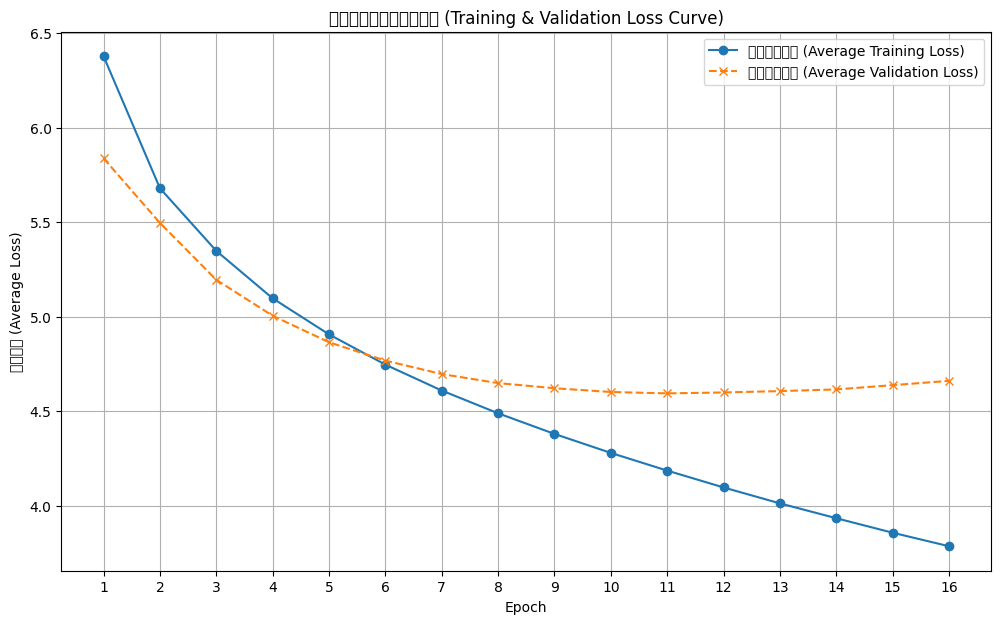

In [21]:
# ## 10. 训练模型 (Train the Model)
# - 设置训练的总轮数 (`num_epochs`)。
# - 迭代训练数据，计算损失，反向传播并更新模型参数。
# - 每个epoch后在验证集上评估模型，并实现早停机制。
# - 打印每个 epoch 的平均训练损失、验证损失和用时。
# - 训练完成后绘制损失变化曲线。

# %%
num_epochs = 50 # 最大训练轮数 (从30修改为50)
patience = 5      # 早停的耐心值
min_delta = 0.0001 # 认为损失有改善的最小变化量

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state_dict_path = "best_poem_model_val.pth" # 保存最佳模型状态字典的路径

print(f"开始训练，最大 {num_epochs} 个 epochs，早停耐心值为 {patience}...")

total_training_start_time = time.time()
epoch_train_losses = [] # List to store average training loss for each epoch
epoch_val_losses = []   # List to store average validation loss for each epoch

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    my_net.train() # 设置为训练模式
    total_train_loss_epoch = 0

    # --- 训练阶段 ---
    if not train_data_loader:
        print("错误: train_data_loader 未定义或为空，无法开始训练。")
        break
        
    for i, (inputs, targets) in enumerate(train_data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = my_net(inputs)
        loss = loss_function(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss_epoch += loss.item()

        if (i + 1) % 50 == 0: # 每50个batch打印一次训练损失
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_data_loader)}], Train Loss: {loss.item():.4f}')
    
    avg_train_loss_epoch = total_train_loss_epoch / len(train_data_loader) if len(train_data_loader) > 0 else float('inf')
    epoch_train_losses.append(avg_train_loss_epoch)

    # --- 验证阶段 ---
    my_net.eval() # 设置为评估模式
    total_val_loss_epoch = 0
    
    if not val_data_loader or len(val_data_loader) == 0:
        print(f"警告: Epoch [{epoch+1}/{num_epochs}] - val_data_loader 为空或未定义，跳过验证阶段。")
        avg_val_loss_epoch = float('inf') 
    else:
        with torch.no_grad(): # 验证时不需要计算梯度
            for inputs_val, targets_val in val_data_loader:
                inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
                outputs_val, _ = my_net(inputs_val)
                val_loss = loss_function(outputs_val.view(-1, vocab_size), targets_val.view(-1))
                total_val_loss_epoch += val_loss.item()
        
        avg_val_loss_epoch = total_val_loss_epoch / len(val_data_loader) if len(val_data_loader) > 0 else float('inf')
    
    epoch_val_losses.append(avg_val_loss_epoch)
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f'Epoch [{epoch+1}/{num_epochs}] 完成. Train Loss: {avg_train_loss_epoch:.4f}, Val Loss: {avg_val_loss_epoch:.4f}, 用时: {epoch_duration:.2f} 秒')
    print("-" * 70)

    # --- 早停检查与模型保存 ---
    if avg_val_loss_epoch < best_val_loss - min_delta:
        best_val_loss = avg_val_loss_epoch
        epochs_no_improve = 0
        torch.save(my_net.state_dict(), best_model_state_dict_path) # 保存最佳模型的状态字典
        print(f"验证损失改善，在 epoch {epoch+1} 保存最佳模型状态字典到 {best_model_state_dict_path}")
    elif avg_val_loss_epoch != float('inf'): 
        epochs_no_improve += 1
        print(f"验证损失没有改善，计数器: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print(f"连续 {patience} 个 epochs 验证损失没有改善，触发早停。")
            break 
    
total_training_end_time = time.time()
total_training_duration = total_training_end_time - total_training_start_time
print("训练完成!")
print(f"总训练用时: {total_training_duration:.2f} 秒")

# --- 绘制损失变化曲线 ---
if epoch_train_losses: 
    plt.figure(figsize=(12, 7))
    epochs_ran = range(1, len(epoch_train_losses) + 1)
    plt.plot(epochs_ran, epoch_train_losses, marker='o', linestyle='-', label='平均训练损失 (Average Training Loss)')
    
    valid_val_losses = [l for l in epoch_val_losses if l != float('inf')]
    if valid_val_losses and len(valid_val_losses) == len(epochs_ran): 
        plt.plot(epochs_ran, epoch_val_losses, marker='x', linestyle='--', label='平均验证损失 (Average Validation Loss)')
    elif valid_val_losses:
         print("警告: 训练损失和验证损失的记录数量不一致，可能未完整绘制验证损失。")

    plt.title('训练与验证损失变化曲线 (Training & Validation Loss Curve)')
    plt.xlabel('Epoch')
    plt.ylabel('平均损失 (Average Loss)')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs_ran)
    plt.show()
else:
    print("未能记录损失，无法绘制曲线。请检查训练循环。")

In [23]:
# ## 11. 保存包含最佳参数的模型 (Save Model with Best Parameters)
# - 首先尝试加载在验证集上表现最佳的模型参数。
# - 然后将这个模型（带有最佳参数）保存为 "model.h5"。
import os
# %%
final_model_save_path = "model.h5"

# 尝试加载最佳模型的状态字典到 my_net
# 首先，确保 my_net 仍然是定义好的模型实例，并且在正确的设备上
my_net_for_saving = PoemNet(vocab_size, embedding_dim, hidden_dim).to(device) # 重新实例化以确保干净的状态

if os.path.exists(best_model_state_dict_path):
    try:
        print(f"正在从 {best_model_state_dict_path} 加载最佳模型参数...")
        my_net_for_saving.load_state_dict(torch.load(best_model_state_dict_path, map_location=device))
        print("最佳模型参数加载成功。")
    except Exception as e:
        print(f"加载最佳模型参数失败: {e}。将保存训练结束时的模型参数。")
        # 如果加载失败，my_net_for_saving 将使用 my_net (训练结束时的状态) 的参数
        # 为了确保这一点，如果上面加载失败，我们应该用 my_net 的状态
        my_net_for_saving.load_state_dict(my_net.state_dict()) # 确保使用最后训练的模型状态
else:
    print(f"未找到最佳模型状态字典文件: {best_model_state_dict_path}。")
    print("将保存训练结束时的模型参数。")
    # 如果最佳模型文件不存在，直接使用 my_net (训练结束时的状态)
    my_net_for_saving.load_state_dict(my_net.state_dict())


try:
    # 保存整个模型对象 (包括结构和已加载的最佳或最终权重)
    torch.save(my_net_for_saving, final_model_save_path)
    print(f"包含最佳（或最终）参数的完整模型已保存到 {final_model_save_path}")
except Exception as e:
    print(f"保存最终模型到 {final_model_save_path} 时发生错误: {e}")
    print("请注意，直接保存整个模型 (torch.save(model, path)) 可能在不同环境中加载时存在一些问题。")
    print(f"作为备选，最佳模型的状态字典（如果成功保存）位于: {best_model_state_dict_path}。")

正在从 best_poem_model_val.pth 加载最佳模型参数...
最佳模型参数加载成功。
包含最佳（或最终）参数的完整模型已保存到 model.h5
